# Create pseudo panel dataset

In this notebook, I create a pseudo-panel based on post-stratification groups. Not every country participated in every ESS round. Moreover, since the post-stratification groups are rather fine-grained not every cohort is represented. This can be solved by zero-weighting these observations in estimation. 

Moreover, some cohorts have a low number of observations. In that case, the GMM estimator from Inoue can account for increased variance in these groups by introducing a GMM weighting matrix that weights based on observations per cohort. 

In [48]:
import pandas as pd
import numpy as np 
import os
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product

### Post-stratification groups

The groups used to calculate the post-stratification weights are age, gender, region, and education. These groups can be considered as pseudo panel cohorts. However, most notably region and education could be endogenous, so they might not be valid if the cohorts are considered in the context of instrumental variables. E.g., if education affects satisfaction with democracy as well as position on the left/right spectrum we would introduce correlation with the error. 

However, categorizing by these groups can be used to determine whether missingness is unevenly distributed across cohorts, and thus whether the cohort means become unrepresentative of the population. This is a common problem when using surveys. The post-stratification weights for the items that are available will then not reflect the population distribution accurately, so we would have to impute or apply inverse probability weighting. 

In [49]:
# Create category corresponding to Age weight
# Define a function to categorize the 'agea' values
def categorize_age(age):
    if pd.isna(age) or age == 0:
        return 0  # Missing
    elif 15 <= age <= 34:
        return 1  # 15-34 years old
    elif 35 <= age <= 54:
        return 2  # 35-54 years old
    elif age >= 55:
        return 3  # 55+ years old
    else:
        return 0  # Default to Missing for any unexpected values
    

# Function to map the education level to a 3-point scale
def categorize_education(level):
    if level in [1, 2]:
        return 1  # Basic Education
    elif level in [3, 4]:
        return 2  # Secondary Education & Vocational Training
    elif level in [5, 6, 7]:
        return 3  # Tertiary Education
    else:
        return None  # Handle unexpected values, if any
    

Here I remove datapoints that can be considered to be missing completely at random (MCAR), for example for participants for whom education could not be recoded to an international scale. Or, datapoints are set to NA for items that might not be MCAR, such as participants who failed to respond to questions. 



In [50]:
df = pd.read_csv(f"{Path.cwd().parent.parent}/ESS/ESS_data.csv", low_memory=False)

# Subset data for which info about education is available
## ES - ISCED = highest level of education
df = df[df.eisced < 10]
df = df[df.eisced != 0] # remove observations for which the eisced could not be harmonised 
df = df[df.essround < 11] # remove round 11, no post stratification weights available yet
df = df[df.gndr != 9] # remove people without gender
df['weight'] = df.pspwght * df.pweight

# Apply the function to create a new column 'age_group'
df['age_group'] = df['agea'].apply(categorize_age)
df = df[df.age_group != 0]

# Apply the function to create a new column with the 3-point scale
df['education_group'] = df['eisced'].apply(categorize_education)
df = df[df.education_group != 0]

df.stfgov = df.stfgov.astype(int)

variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround'] # create cohorts

# Recode missing data (77=refusal, 88=dont know, 99=no answer)
df.loc[:,variables_of_interest] = df.loc[:,variables_of_interest].replace({77: np.nan, 88: np.nan, 99: np.nan}).astype(pd.Int64Dtype())


df = df[variables_of_interest + grouping_variables]

C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_1180\3690847270.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   7,    5,    5,    2,    3,    3,    7,    5,    7, <NA>,
 ...
    2,    6,    5,    8,    5,    8,    6,    2,    7,    3]
Length: 413372, dtype: Int64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,variables_of_interest] = df.loc[:,variables_of_interest].replace({77: np.nan, 88: np.nan, 99: np.nan}).astype(pd.Int64Dtype())
C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_1180\3690847270.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   6,    6,    8,    8,    7,    2,    7, <NA>,    6,    5,
 ...
   10,    4,    9,    8,    9,    5,    6,    5,    5,    7]
Length: 413372, dtype: Int64' has dtype incompatible with int64, please e

## Create the pseudo panel

The pseudo panel is created by first creating a long dataframe with all possible combinations of cohorts. 

In [51]:
variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround']

# Step 1: Create a full grid of all possible cohorts (including time)
unique_values = {col: df[col].unique() for col in grouping_variables}
full_cohort_space = pd.DataFrame(list(product(*unique_values.values())), columns=grouping_variables)

# Step 2: Group the actual data and calculate means for the variables of interest
grouped_mean_df = df.groupby(grouping_variables)[variables_of_interest].mean().reset_index()

# Step 3: Merge the full cohort space with the grouped data (this will introduce NaNs for missing cohorts)
full_pseudo_df = pd.merge(full_cohort_space, grouped_mean_df, on=grouping_variables, how='left')


- Cast to a tensor of shape NxTxK+1 (since Y is included)

Some cohorts might not have any observations in the actual dataset. When the full cohort space is merged with the actual dataset these will automatically be set to NA. 

In [52]:
import numpy as np

# Define the grouping variables (the cohorts) and the variables of interest
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group']
variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']

# Step 1: Sort the DataFrame by the grouping variables and time point (essround)
full_pseudo_df = full_pseudo_df.sort_values(grouping_variables + ['essround'])
# Step 2: Make sure there is exactly one observation per cohort per time point (i.e., no duplicates)
# If duplicates exist, you'll need to handle them appropriately (e.g., by dropping or aggregating)
# For now, let's assume there are no duplicates

# Step 3: Convert to a NumPy array and reshape into (N, T, K)
# N = number of unique cohorts, T = number of time points, K = number of variables of interest
N = full_pseudo_df.drop_duplicates(subset=grouping_variables).shape[0]  # Number of unique cohorts
T = full_pseudo_df['essround'].nunique()  # Number of time points
K = len(variables_of_interest)  # Number of variables of interest

# Extract the data to be reshaped
data_values = full_pseudo_df[variables_of_interest].values

# Reshape the data into a 3D array (N x T x K)
tensor = data_values.reshape(N, T, K)

# Step 4: Verify the shape of the resulting tensor
print("Shape of the tensor (N, T, K):", tensor.shape)


Shape of the tensor (N, T, K): (684, 10, 5)


- Create the weighting matrix $W$
    - Cell in $W$ corresponds to the number of observations for cohort N at time T
    - Cells that are 0 will be set to NA

In [53]:
# Step 1: Create a full grid of all possible cohorts (including time)
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround']
## Same as before, however, the NaN's will be 0 since no observations are available for those timepoints
unique_values = {col: df[col].unique() for col in grouping_variables}
full_cohort_space = pd.DataFrame(list(product(*unique_values.values())), columns=grouping_variables)

# Step 2: Group the actual data and count the number of observations per cohort
grouped_count_df = df.groupby(grouping_variables)[variables_of_interest].size().reset_index(name = 'count')

# Step 3: Merge the full cohort space with the grouped data (this will introduce NaNs for missing cohorts)
full_weight_df = pd.merge(full_cohort_space, grouped_count_df, on=grouping_variables, how='left')


# Step 4: Replace NaN values with 0 in the 'count' column
full_weight_df['count'] = full_weight_df['count'].fillna(0)


In [54]:
full_cohort_space.columns

Index(['cntry', 'gndr', 'age_group', 'education_group', 'essround'], dtype='object')

- Reshape it into a NxT weighting matrix

In [55]:
# Pivot the DataFrame to create a matrix of counts for each cohort and ESS round
pivot_counts = full_weight_df.pivot_table(index=grouping_variables[:-1], columns='essround', values='count')

# Convert the pivoted DataFrame into a NumPy array
weighting_matrix = pivot_counts.values

# Show the shape of the resulting weighting matrix (N x T)
print("Shape of the weighting matrix (N, T):", weighting_matrix.shape)


print(f"Missing observations: {np.sum(weighting_matrix == 0)}")
print(f"Available observations: {np.sum(weighting_matrix)}")

Shape of the weighting matrix (N, T): (684, 10)
Missing observations: 2844
Available observations: 413372.0


- Percentage NA per round

In [56]:
# Checks how many entries are 0, which correspond to NA entries
((pivot_counts == 0).sum(axis = 0))/pivot_counts.shape[0]

essround
1     0.657895
2     0.605263
3     0.631579
4     0.473684
5     0.289474
6     0.236842
7     0.447368
8     0.394737
9     0.236842
10    0.184211
dtype: float64

----------------------

# Analyse the source of the missingness

In [57]:
# Functions
from IPython.display import display, HTML
# Function to display scrollable DataFrame
def display_scrollable_dataframe(df, max_height=200, max_width=1000):
    display(HTML(f"""
    <div style="max-height: {max_height}px; max-width: {max_width}px; overflow-y: scroll; overflow-x: auto;">
        {df.to_html()}
    </div>
    """))

In [58]:
# Step 1: Create a binary indicator for missingness
full_pseudo_df['is_missing'] = full_pseudo_df[variables_of_interest].isnull().any(axis=1).astype(int)

# Optional: You can also calculate the percentage of missing values for each cohort
full_pseudo_df['missing_percentage'] = full_pseudo_df[variables_of_interest].isnull().mean(axis=1) * 100


Here we see which countries were not included in each round of ESS

In [59]:
# Group the data by country and ESS round
grouped_country_round = full_pseudo_df.groupby(['cntry', 'essround'])['is_missing'].mean().reset_index()

# Create a pivot table where each row is a country and each column is an ESS round
pivot_missing_country_round = grouped_country_round.pivot_table(index='cntry', columns='essround', values='is_missing')

# Step 2: Identify countries with entire rounds missing (i.e., all cohorts missing for a given round)
# If a value is 1 for an entire column, it means that the round is completely missing for that country
fully_missing_rounds = pivot_missing_country_round[pivot_missing_country_round == 1].dropna(how='all')

# Display the countries and ESS rounds with complete missingness
# print(fully_missing_rounds)

display_scrollable_dataframe(fully_missing_rounds)


essround,1,2,3,4,5,6,7,8,9,10
cntry,,,,,,,,,,
AL,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0
AT,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
BG,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN
CY,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN
CZ,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
EE,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FI,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
FR,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Step 2: Aggregate missingness by each cohort (grouping variables excluding 'essround')
missing_by_cohort = full_pseudo_df.groupby(grouping_variables)['is_missing'].mean().reset_index()

# You can also sort to see which cohorts have the highest missingness
missing_by_cohort = missing_by_cohort.sort_values(by='is_missing', ascending=False)

# Display the most missing cohorts
# print(missing_by_cohort)

display_scrollable_dataframe(missing_by_cohort)

,cntry,gndr,age_group,education_group,essround,is_missing
0,AL,1,1,1,1,1.0
3880,LT,2,1,2,1,1.0
3892,LT,2,1,3,3,1.0
3891,LT,2,1,3,2,1.0
3890,LT,2,1,3,1,1.0
3883,LT,2,1,2,4,1.0
3882,LT,2,1,2,3,1.0
3881,LT,2,1,2,2,1.0
3873,LT,2,1,1,4,1.0
3941,LT,2,3,2,2,1.0


Number of cohorts available and missing after grouping. This is using the post-stratification weights, which is a method that will likely still have to be changed given IV requirements.

In [61]:
missing_by_cohort.is_missing.value_counts()

is_missing
0.0    3995
1.0    2845
Name: count, dtype: int64

In [62]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Pivot the data for the heatmap
# missing_heatmap_data = full_pseudo_df.pivot_table(index=grouping_variables[:-1], columns='essround', values='is_missing')

# # Plot the heatmap
# plt.figure(figsize=(12,8))
# sns.heatmap(missing_heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Missing (1=Yes, 0=No)'}, linewidths=.5)
# plt.title('Missingness Across Cohorts and Time Points')
# plt.xlabel('ESS Round (Time Points)')
# plt.ylabel('Cohorts')
# plt.show()


We see that some countries only participated in a few rounds. By 0-weighting the missing observations we are still able to include the data for estimation, if this is valid practice.

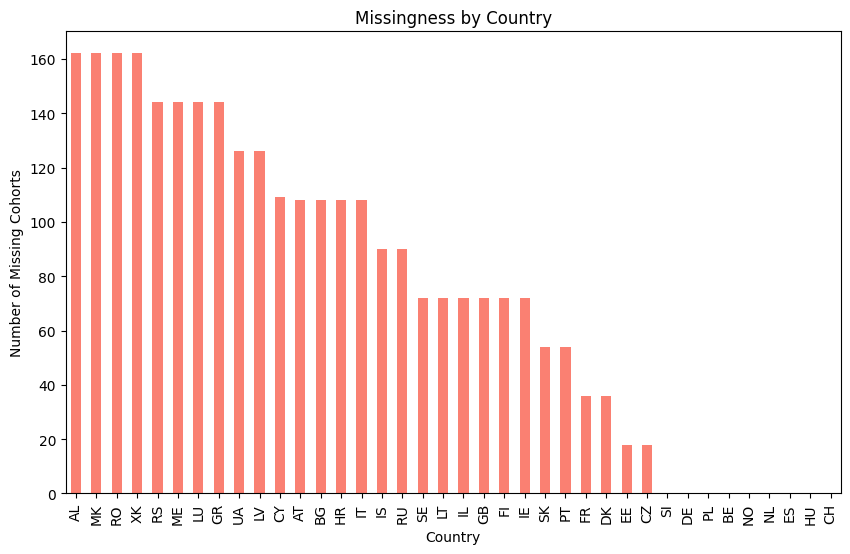

In [63]:
# Step 3: Aggregate missingness by country, gender, etc.
missing_by_group = full_pseudo_df.groupby('cntry')['is_missing'].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10,6))
missing_by_group.plot(kind='bar', color='salmon')
plt.title('Missingness by Country')
plt.xlabel('Country')
plt.ylabel('Number of Missing Cohorts')
plt.show()


-------------------